# Detalles del proyecto




## Datos Acádemicos

### Universidad Nacional de Rosario

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura

#### T.U.I.A

##### Aprendizaje Automático II


### Trabajo Práctico 2

### Redes Recurrentes

#### 8/07/2024

#### Fabio Giampaoli, Arevalo Ezequiel

## Enunciado

### Audio MNIST

**Descripción**:
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

**Dataset**:
https://www.tensorflow.org/datasets/catalog/spoken_digit


El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.



**Objetivo**:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

- Modelo convolucional sobre los espectrogramas de los clips.
- Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

**Entrega**:

La entrega debe incluir:
- Código fuente de la solución implementada en Google Colab, que incluya:
- Análisis previo y preprocesamiento del set de datos.
- Definición y entrenamiento del modelo.
- Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

# Entorno

## Librerias

In [1]:
import torch
# from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
# import torchvision
# from torchvision.datasets.utils import download_url
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

# import tarfile
import os
# import csv
import pathlib
import shutil

import librosa
# import pandas as pd
import numpy as np
import librosa.display
from IPython import display
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

## Procesamiento

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return
        len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Dataset

## Descarga

In [4]:
# se descarga el dataset desde tensorflow directamente
DATASET_PATH = '/content/data2'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.01.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data2')


1489096277/1489096277 [==============================] - 14s 0us/step


In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['_background_noise_' 'zero' 'sheila' 'speech_commands_v0.01.tar.gz' 'dog'
 'testing_list.txt' 'right' 'validation_list.txt' 'happy' 'one' 'down'
 'three' 'eight' 'nine' 'five' 'up' 'go' 'four' 'LICENSE' 'cat' 'tree'
 'wow' 'yes' 'left' 'bird' 'two' 'seven' 'no' 'marvin' 'off' 'house' 'bed'
 'on' 'six' 'stop']


In [6]:
# filtramos las clases solo a los digitos
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

data2_path = '/content/data2'
all_items = os.listdir(data2_path)

for item in all_items:
    item_path = os.path.join(data2_path, item)
    if os.path.isdir(item_path) and item not in labels:
        shutil.rmtree(item_path)
        print(f"Removed folder: {item_path}")
    elif not os.path.isdir(item_path):
        os.remove(item_path)
        print(f"Removed file: {item_path}")

Removed folder: /content/data2/_background_noise_
Removed folder: /content/data2/sheila
Removed file: /content/data2/speech_commands_v0.01.tar.gz
Removed folder: /content/data2/dog
Removed file: /content/data2/testing_list.txt
Removed folder: /content/data2/right
Removed file: /content/data2/validation_list.txt
Removed folder: /content/data2/happy
Removed folder: /content/data2/down
Removed folder: /content/data2/up
Removed folder: /content/data2/go
Removed file: /content/data2/LICENSE
Removed folder: /content/data2/cat
Removed folder: /content/data2/tree
Removed folder: /content/data2/wow
Removed folder: /content/data2/yes
Removed folder: /content/data2/left
Removed folder: /content/data2/bird
Removed folder: /content/data2/no
Removed folder: /content/data2/marvin
Removed folder: /content/data2/off
Removed folder: /content/data2/house
Removed file: /content/data2/README.md
Removed folder: /content/data2/bed
Removed folder: /content/data2/on
Removed folder: /content/data2/stop


In [7]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['zero' 'one' 'three' 'eight' 'nine' 'five' 'four' 'two' 'seven' 'six']



## Conjuntos

In [8]:
# dividimos el dataset en 80/20 en train y validacion
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 23666 files belonging to 10 classes.
Using 18933 files for training.
Using 4733 files for validation.

label names: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [9]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

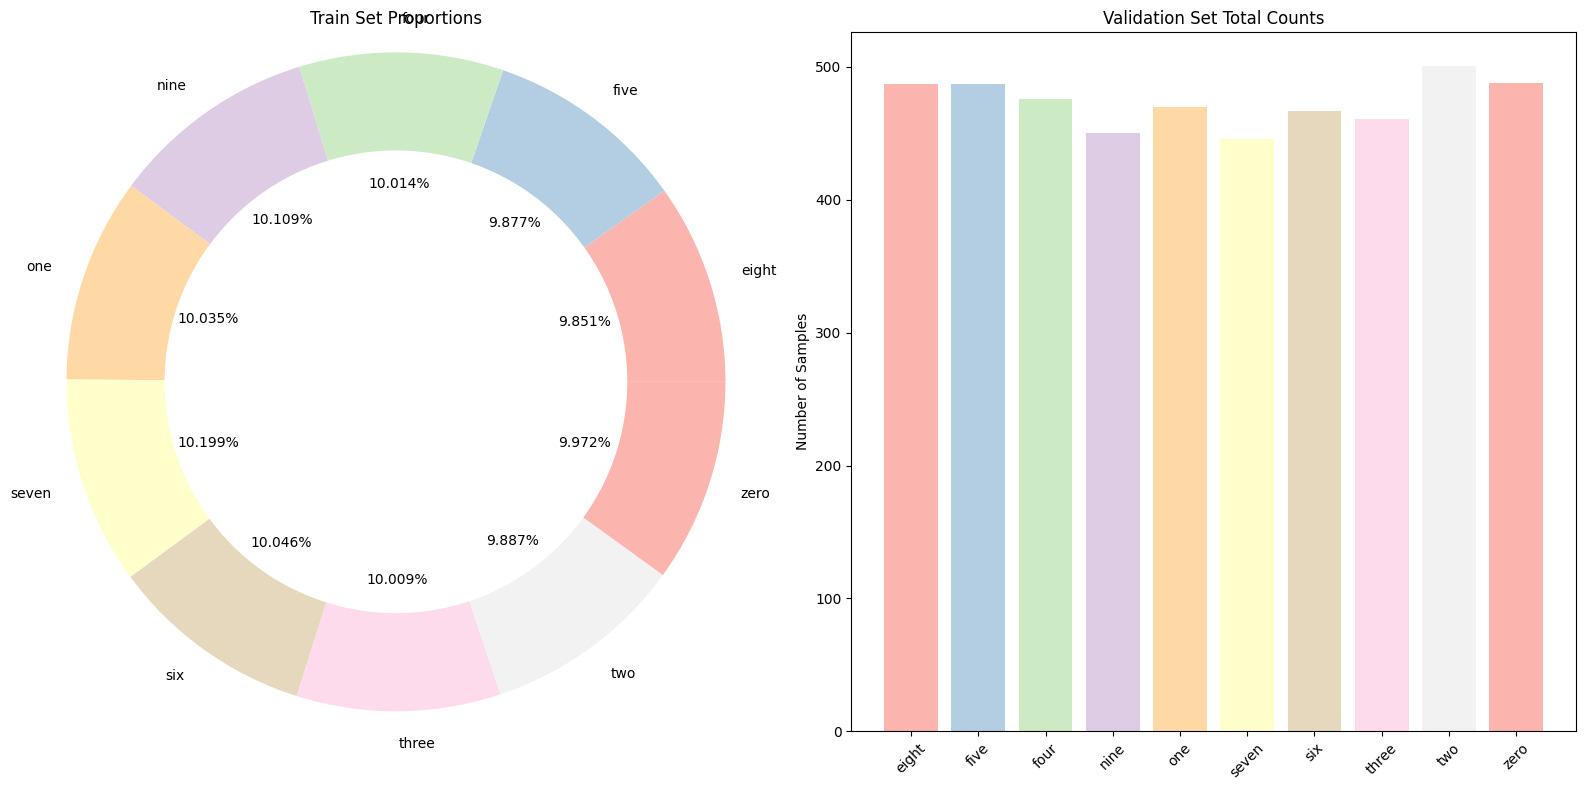

In [10]:
# para visualizar el balance de las clases y distribucion del dataset
train_class_counts = {label: 0 for label in label_names}
val_class_counts = {label: 0 for label in label_names}

# Count samples in train_ds
for _, labels in train_ds:
    label_counts = np.bincount(labels.numpy(), minlength=len(label_names))
    for idx, count in enumerate(label_counts):
        train_class_counts[label_names[idx]] += count

# Count samples in val_ds
for _, labels in val_ds:
    label_counts = np.bincount(labels.numpy(), minlength=len(label_names))
    for idx, count in enumerate(label_counts):
        val_class_counts[label_names[idx]] += count

train_counts = [train_class_counts[label] for label in label_names]
val_counts = [val_class_counts[label] for label in label_names]


plt.figure(figsize=(16, 8))

# Donut chart
plt.subplot(1, 2, 1)
plt.title('Train Set Proportions')
plt.pie(train_counts, labels=label_names, autopct='%1.3f%%', colors=plt.cm.Pastel1.colors)
circle = plt.Circle((0,0), 0.7, color='white')
plt.gca().add_artist(circle)
plt.axis('equal')

# Bar plot
plt.subplot(1, 2, 2)
plt.title('Validation Set Total Counts')
plt.bar(label_names, val_counts, color=plt.cm.Pastel1.colors)
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

## Ondas de audio

In [11]:
# normalizar los datos eliminando dimensión adicional
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [12]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


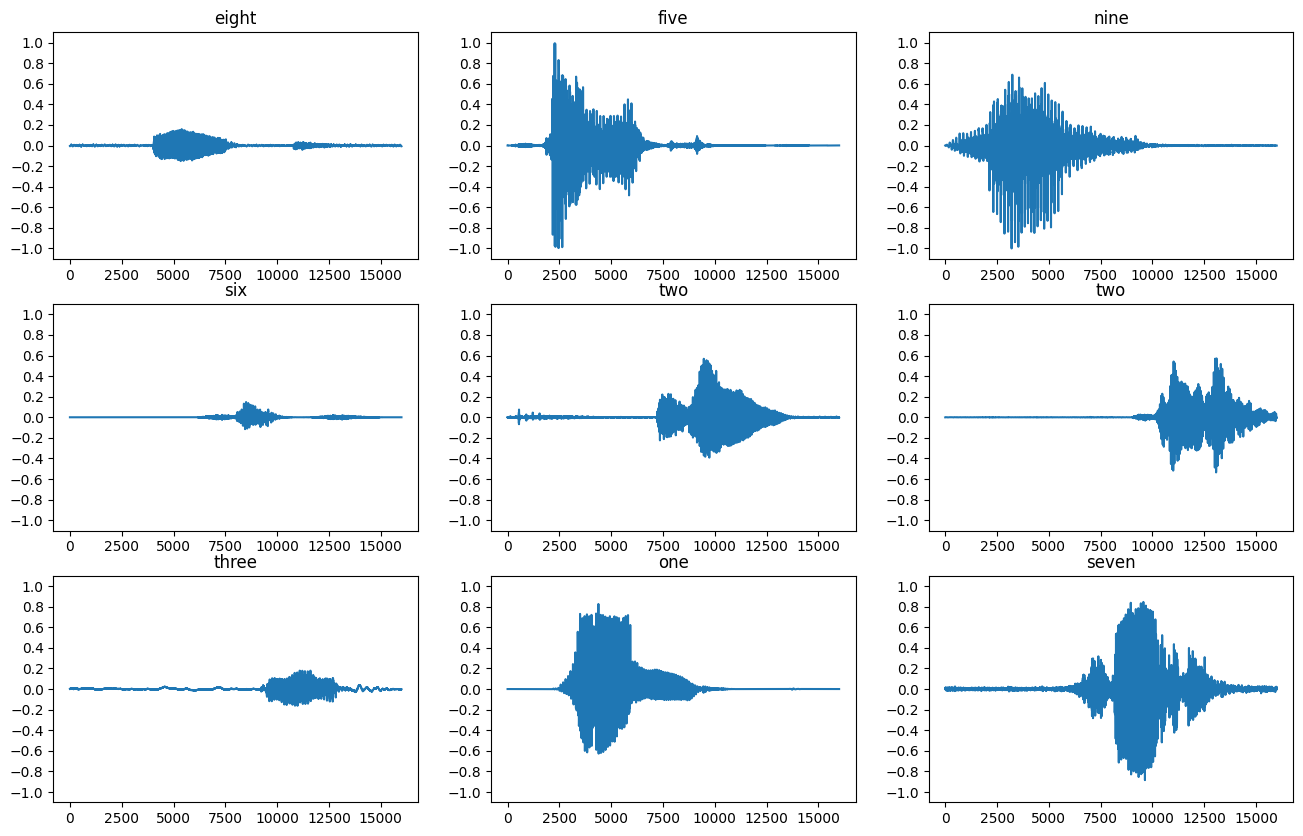

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Redes Convolucionales


## Conversion

In [14]:
def get_spectrogram(waveform):
  # calcula la transformada de Fourier de corto tiempo de la forma de onda
  # divide la señal de audio en ventanas
  # y calcula la transformada de Fourier para cada segmento.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:
def make_spec_ds(ds):
  # genera el espectrograma de cada elemento del dataset dado
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

## Visualización

In [17]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: eight
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: five
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


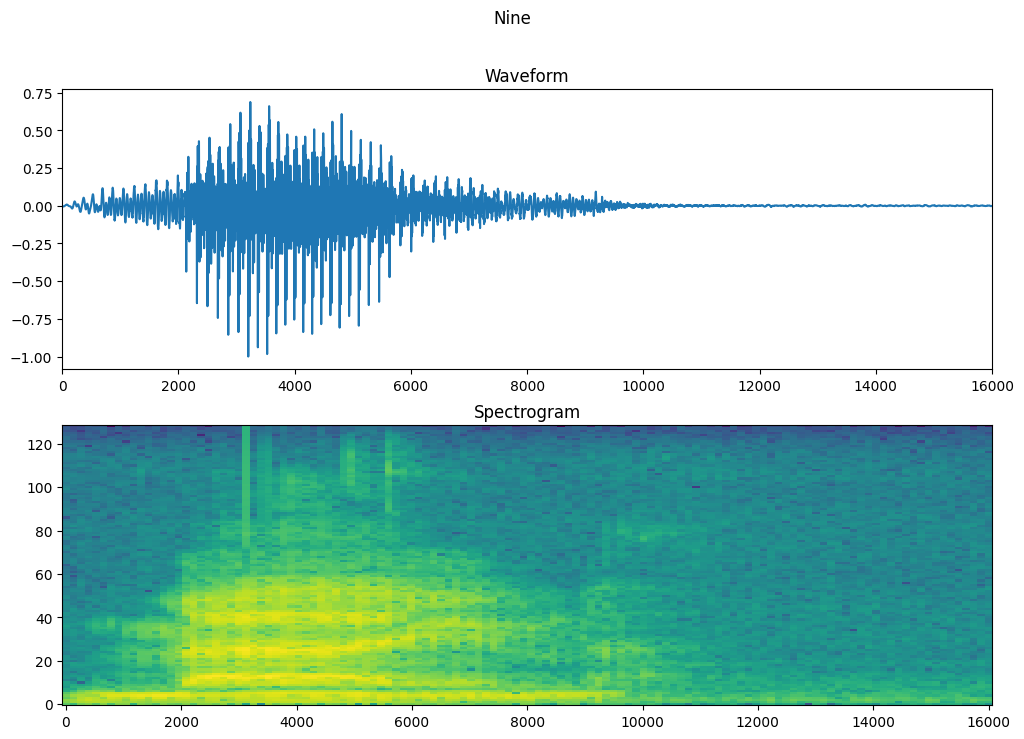

In [18]:
def plot_spectrogram(spectrogram, ax):
  # visualizar el espectrograma de un audio
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# forma de onda del auio
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

# forma de espectrograma
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

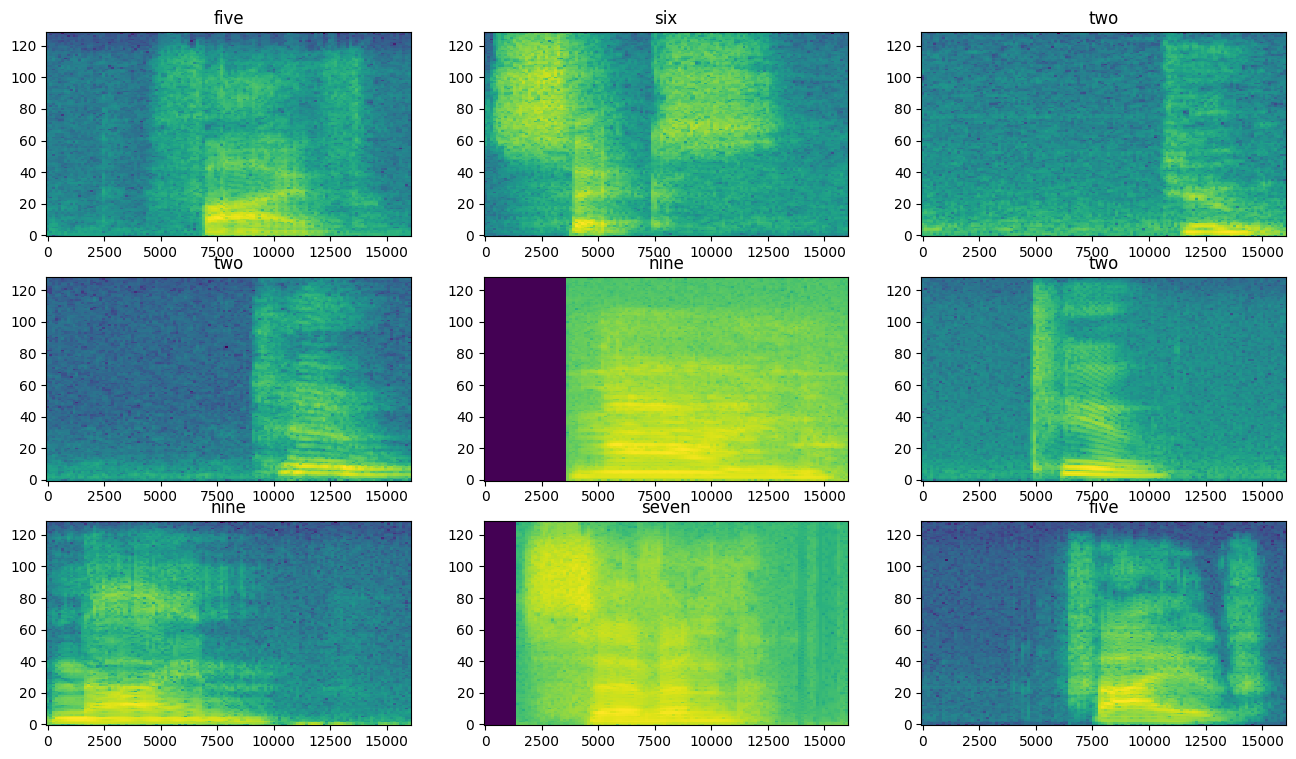

In [19]:
# toma muestra para visualizar los espectrogramas
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Arquitectura

In [ ]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)
print('Input shape:', input_shape)

# aplica una capa de normalizacion de los datos
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),  # Redimensionar la entrada
    norm_layer, # normalizar
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
296/296 [==============================] - 30s 78ms/step - loss: 1.3621 - accuracy: 0.5482 - val_loss: 0.7481 - val_accuracy: 0.7845
Epoch 2/50
296/296 [==============================] - 24s 79ms/step - loss: 0.6969 - accuracy: 0.7786 - val_loss: 0.4917 - val_accuracy: 0.8565
Epoch 3/50
296/296 [==============================] - 23s 78ms/step - loss: 0.5035 - accuracy: 0.8386 - val_loss: 0.3905 - val_accuracy: 0.8813
Epoch 4/50
296/296 [==============================] - 23s 77ms/step - loss: 0.4059 - accuracy: 0.8703 - val_loss: 0.3793 - val_accuracy: 0.8882
Epoch 5/50
296/296 [==============================] - 23s 76ms/step - loss: 0.3479 - accuracy: 0.8863 - val_loss: 0.3157 - val_accuracy: 0.9034
Epoch 6/50
296/296 [==============================] - 23s 78ms/step - loss: 0.2986 - accuracy: 0.9031 - val_loss: 0.3192 - val_accuracy: 0.9056
Epoch 7/50
296/296 [==============================] - 22s 75ms/step - loss: 0.2644 - accuracy: 0.9126 - val_loss: 0.3053 - val_accuracy:

Notar que se ha detenido antes de llegar a las 50 epocas. Con 18 epocas ha encontrado un buen nivel de accuracy superiores a 90% tanto en train como en validation.

## Validación

Text(0, 0.5, 'Accuracy [%]')

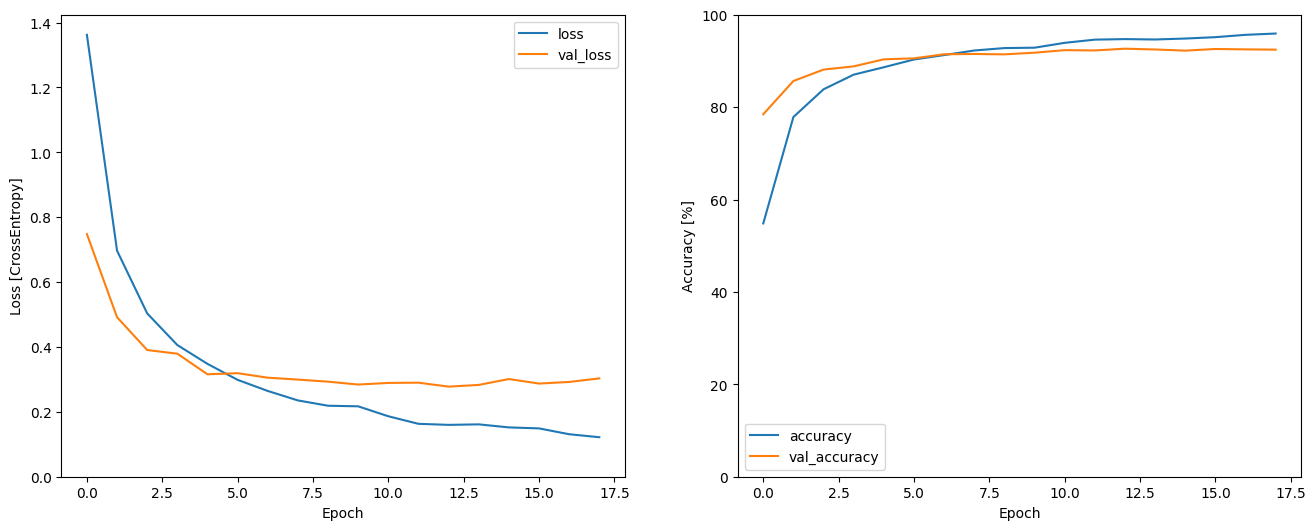

In [ ]:
metrics = history.history

# evolucion del loss en el entrenamiento
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# evolucion de la accuracy en el entrenamiento
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Notar que a pesar de metricas relativamente buenas, el modelo muestra leve desbalanceo luego de las cinco epocas, indicando que a partir de este punto comienza a sufrir de overfitting.

74/74 [==============================] - 5s 71ms/step


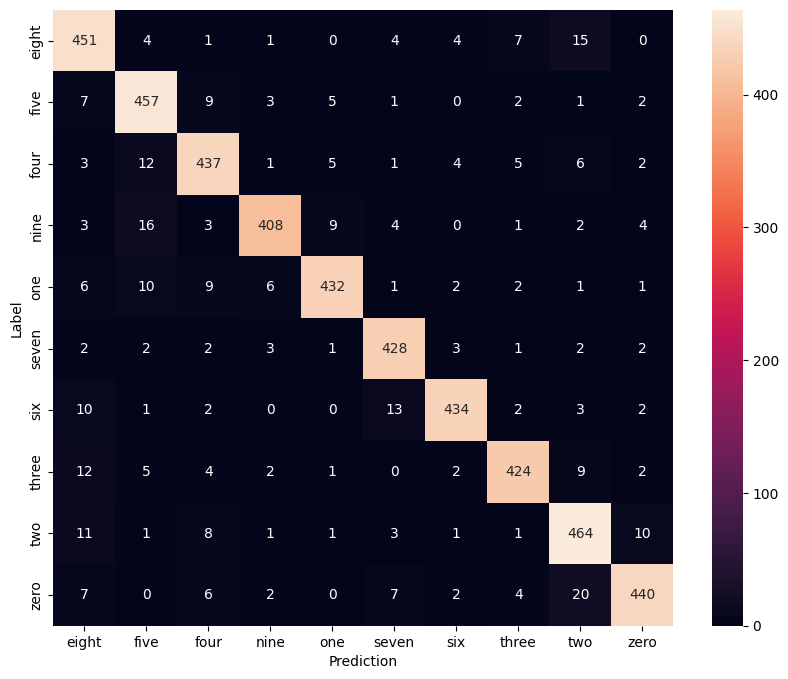

In [ ]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

La matrix de confunsion muestra que se acerta casi siempre a la clase correcta, por lo que las predicciones son relativamente confiables, salvo casos particulares minoritarios que caen en falsos positivos.

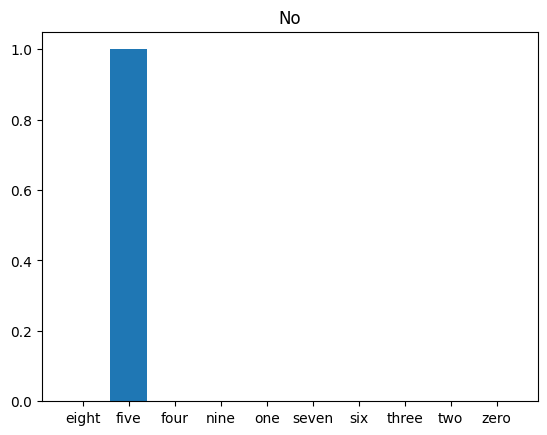

In [ ]:
x = data_dir/'five/042ea76c_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Redes Recurrentes

## Conversion

In [ ]:
def get_amplitude_vectors(waveform):
    # obtener directamente los vectores de amplitud resultantes
    # de la STFT de la señal de audio
    stft = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    amplitude_vectors = tf.abs(stft)
    return amplitude_vectors

def make_freq_vector_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_amplitude_vectors(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

def plot_amplitude_vectors(amplitude_vectors, ax):
    ax.imshow(amplitude_vectors.T, aspect='auto', origin='lower', interpolation='none')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

In [ ]:
train_freq_vector_ds = make_freq_vector_ds(train_ds)
val_freq_vector_ds = make_freq_vector_ds(val_ds)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_freq_vector_ds.map(lambda spec, label: spec))

train_freq_vector_ds = train_freq_vector_ds.map(lambda spec, label: (norm_layer(spec), label))
val_freq_vector_ds = val_freq_vector_ds.map(lambda spec, label: (norm_layer(spec), label))

## Visualización

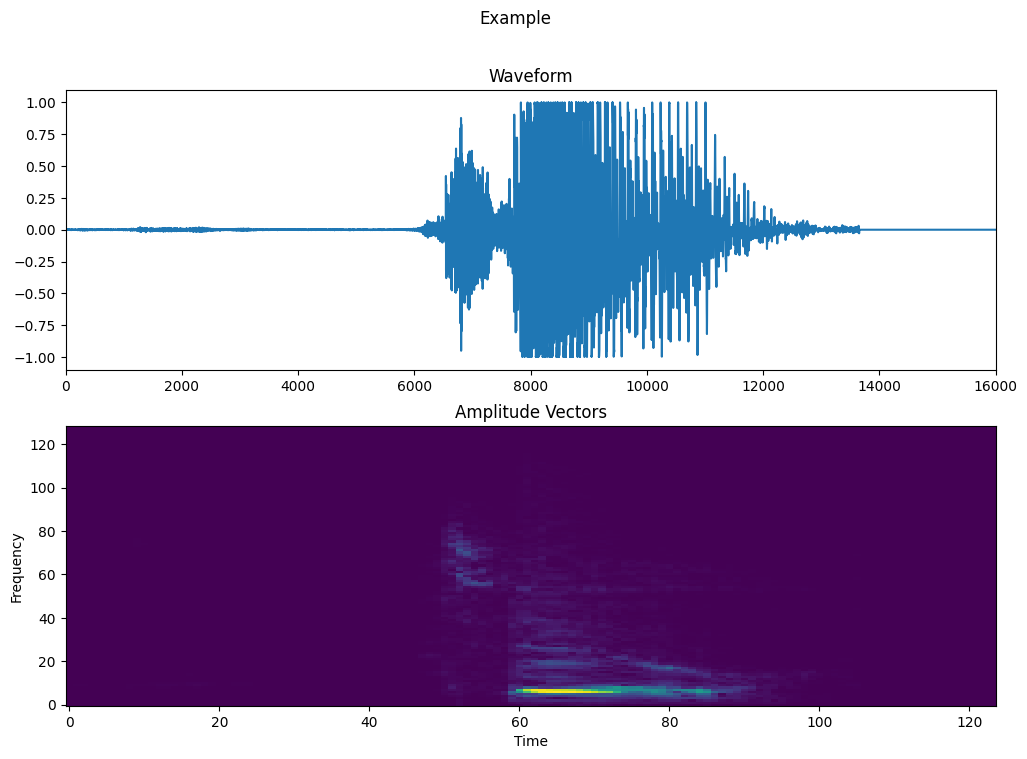

In [ ]:
for example_waveforms, example_labels in train_ds.take(1):
    break

# Transformar el waveform a vectores de amplitud de frecuencia
example_amplitude_vectors = get_amplitude_vectors(example_waveforms)

# Visualizar un ejemplo
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(example_waveforms[0].shape[0])
axes[0].plot(timescale, example_waveforms[0].numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_amplitude_vectors(example_amplitude_vectors[0].numpy(), axes[1])
axes[1].set_title('Amplitude Vectors')
plt.suptitle('Example')
plt.show()

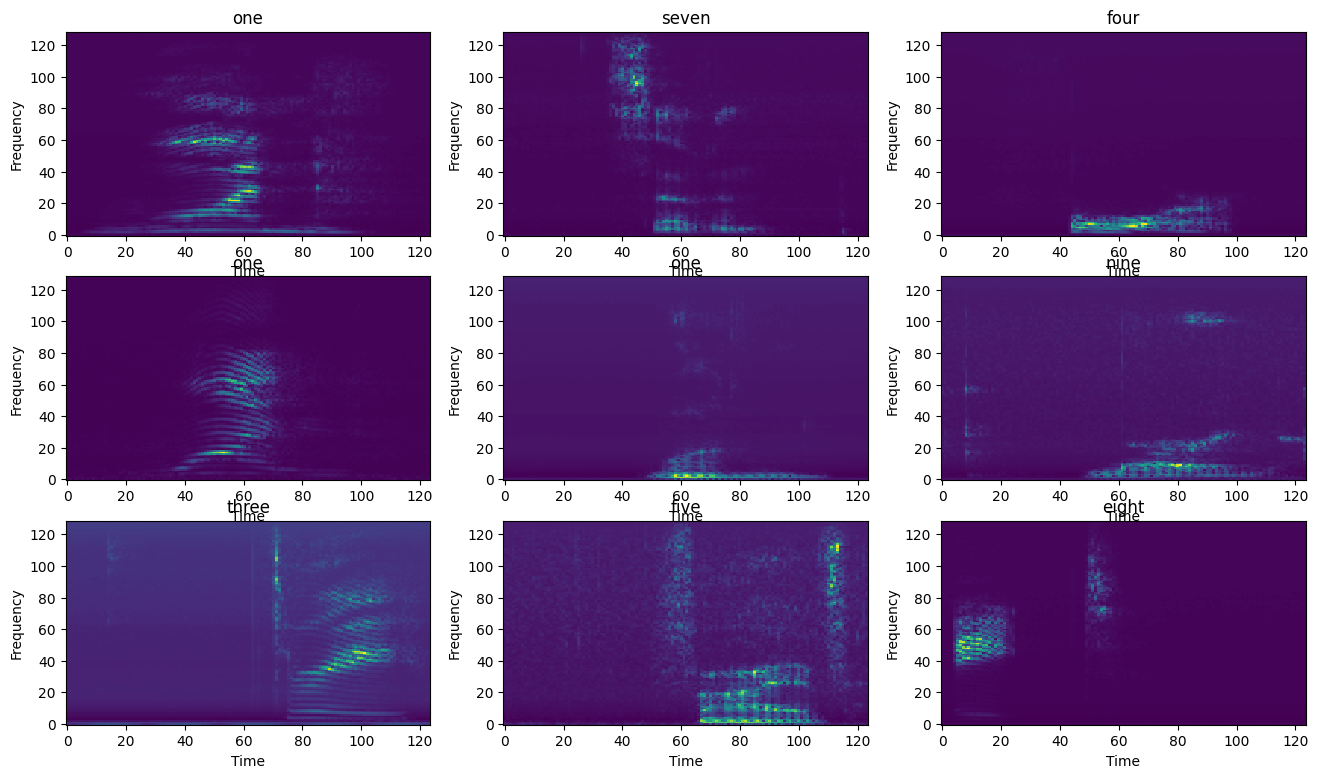

In [ ]:
# Obtener ejemplos del dataset
for example_amplitude_vectors, example_labels in train_freq_vector_ds.take(1):
    break

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_amplitude_vectors(example_amplitude_vectors[i].numpy(), ax)
    ax.set_title(label_names[example_labels[i].numpy()])

plt.show()


## Arquitectura

In [ ]:
model = models.Sequential([
    layers.Input(shape=(None, 129)), # debido a la salida de la STFT
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(len(labels))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 128)         132096    
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 61)                7869      
                                                                 
Total params: 288061 (1.10 MB)
Trainable params: 288061 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# entrenamos solo con 20 epocas debido a que el modelo anterior paro en 18
history = model.fit(
    train_freq_vector_ds,
    validation_data=val_freq_vector_ds,
    epochs=20
)

Epoch 1/20
296/296 [==============================] - 39s 108ms/step - loss: 2.1698 - accuracy: 0.2472 - val_loss: 1.3458 - val_accuracy: 0.5536
Epoch 2/20
296/296 [==============================] - 27s 89ms/step - loss: 1.0129 - accuracy: 0.6753 - val_loss: 0.6013 - val_accuracy: 0.8139
Epoch 3/20
296/296 [==============================] - 31s 103ms/step - loss: 0.5666 - accuracy: 0.8317 - val_loss: 0.4738 - val_accuracy: 0.8451
Epoch 4/20
296/296 [==============================] - 30s 102ms/step - loss: 0.4131 - accuracy: 0.8758 - val_loss: 0.3603 - val_accuracy: 0.8887
Epoch 5/20
296/296 [==============================] - 25s 84ms/step - loss: 0.3196 - accuracy: 0.9052 - val_loss: 0.3308 - val_accuracy: 0.8952
Epoch 6/20
296/296 [==============================] - 25s 83ms/step - loss: 0.2657 - accuracy: 0.9207 - val_loss: 0.2745 - val_accuracy: 0.9121
Epoch 7/20
296/296 [==============================] - 27s 90ms/step - loss: 0.2268 - accuracy: 0.9299 - val_loss: 0.2806 - val_accura

Notar que se logra una precision muy similar al anterior modelo, con 20 epocas alcanza presiciones del 96 y 92% para train y validation. Que de hecho es mejor resultado que el anterior, y podria continuar el entrenamiento, ya que el entrenamiento se detuvo no por dejo de mejorar, sino por la limitacion de las 20 epocas.

## Validación

Text(0, 0.5, 'Accuracy [%]')

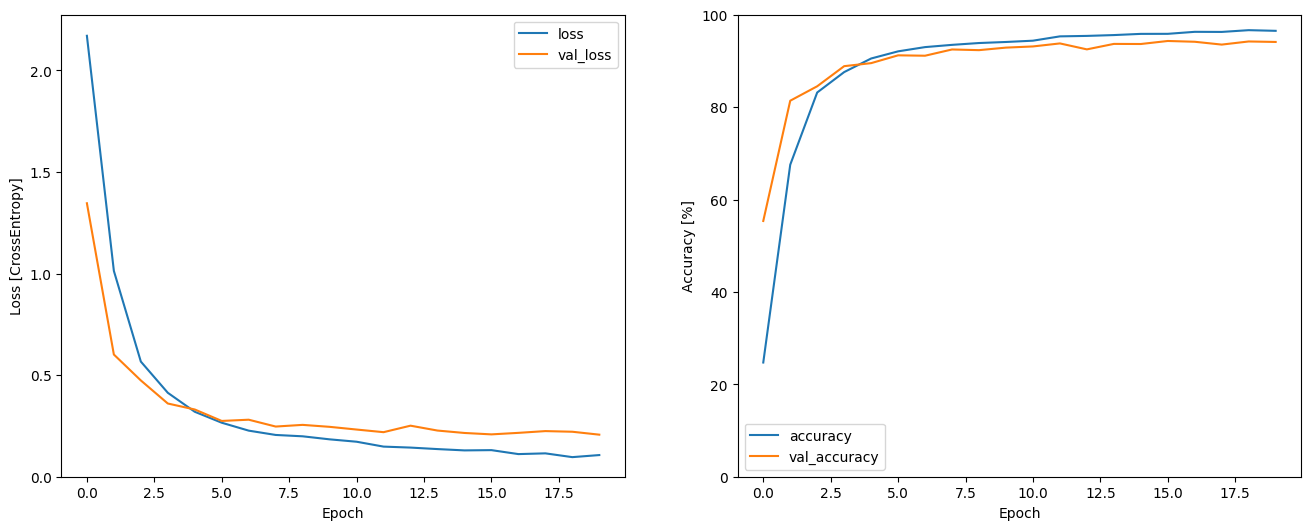

In [ ]:
metrics = history.history

# evolucion del loss
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# evolucion del accuracy
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Notamos una convergencia mas balanceada entre el train y el validation, por lo que no solo mejora levemente las metricas al modelo convolucional, sino que permite generalizar mas evitando el sobreajuste.

74/74 [==============================] - 8s 87ms/step


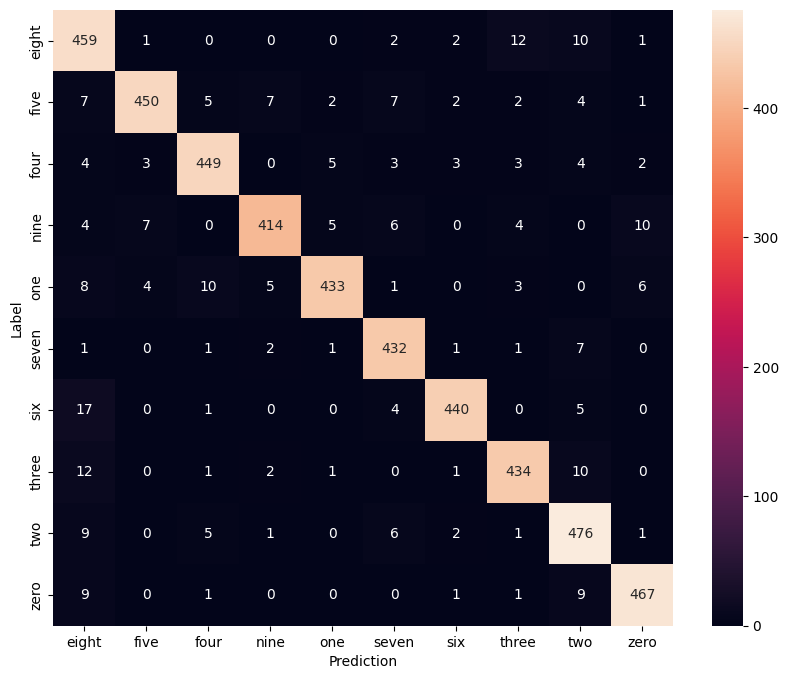

In [ ]:
y_pred = model.predict(val_freq_vector_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(val_freq_vector_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

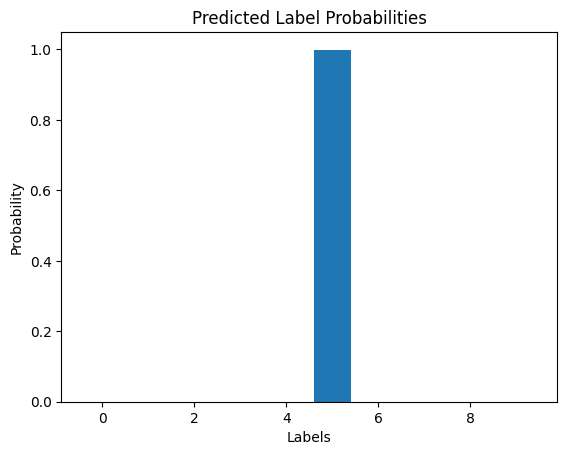

In [ ]:
label_names = np.array(labels)
num_labels = len(labels)

# tomamos un ejemplo cualquiera de los cincos
x = data_dir/'five/042ea76c_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

x = get_amplitude_vectors(x)
x = x[tf.newaxis,...]
x = norm_layer(x)

prediction = model(x)
prediction_probabilities = tf.nn.softmax(prediction[0])

# Graficar las probabilidades de las etiquetas
plt.bar(label_names, prediction_probabilities)
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Predicted Label Probabilities')
plt.show()

# Reproducir el audio
display.display(display.Audio(waveform, rate=16000))

Indica que es un cinco casi con un 100% de propabilidad.

# Conclución

Se ha tomado de un dataset publico los archivos de audio organizados por categoria. A partir de estos  archivos de audio en formato wav se han generado dos datasets:
- Un dataset  sobre los archivos indicados pero en tomando sus espectrogramas como imagenes, convirtiendo las ondas de audio en imagenes representativas de los sonidos.

Con este dataset se ha contruido y entranadoun modelo con capas  convoluciones con el fin de que dicha arquitectura sea capaz de  indentificar con precision la clase en base a su espectrograma.

El rendimiento del modelo es relativamente bueno, alcanzando mas de un 90% de presicion en las predicciones, con tan solo 18 epocas de entramiento. A su vez s nota una tendencia al sobreajuste a medida que se crece  en numero de epocas.

- Un dataset sobre los archivos de audio, tomando directamente los vectores de amplitud frecuencial de los datos, interpretando los datos no como una imagen, sino como tensores que represetan las ondas de audio directamente.

El segundo modelo en una red neuronal recurrente que se alimenta de estos tensores para el entrenamiento.

En este caso notamos una convergencia levemente superior y balanceada comparada  al  modelo basado en capas convoluciones. Con 20 epocas alcanza presiciones del 96% y podemos notar un modelo mas generalista que el anterior.

El modelo de redes recurrentes entrenado con vectores de amplitud de frecuencia  es preferido para la resolción de este problema de clasifición.